In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import os, re, sys
from tqdm.notebook import tqdm
sys.path.append("../src")

import torch
import pyro
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch

In [59]:
import metagnn as mg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
config = mg.tl.MetaGNNConfig(
    batch_size = 16,
    hidden_dim = 16,
    latent_dim = 2,
    num_layers = 2,
    num_components = 2,
    learning_rate = .1,
    num_epochs = 20,
    num_workers = 1,
    k = 3,
)
mg.tl.train_metagnn("../data/combined.fasta", config, run_id="20241124-201633")

Loading fasta: 0it [00:00, ?it/s]

Building graphs:   0%|          | 0/30 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

(tensor([[0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]]), DataBatch(edge_index=[2, 262144], edge_proba=[262144], num_nodes=65536, batch=[65536], ptr=[17])) (tensor([[-0.5899,  0.1680],
        [-1.1592,  0.5411],
        [-1.1592,  0.5411],
        [-0.3123, -0.0138],
        [-0.3941,  0.0398],
        [-0.4568,  0.0809],
        [-1.1592,  0.5411],
        [-0.4084,  0.0491],
        [-1.1592,  0.5411],
        [-0.3941,  0.0398],
        [-1.1592,  0.5411],
        [-1.1592,  0.5411],
        [-0.5414,  0.1363],
        [-1.1592,  0.5411],
        [-1.1592,  0.5411],
        [-0.6375,  0.1992]], grad_fn=<AddmmBackward0>), tensor([[0.8899, 0.9837],
        [0.8755, 1.0083],
        [0.8755, 1.0083],
        [0.8970, 0.9719],
        [0.8949, 0.9753],
        [0.8933, 0.9780],
        [0.87

KeyboardInterrupt: 

In [53]:
vae = mg.tl.load_model("20241124-201633")

In [55]:
dataset = mg.tl.MetagenomeDataset("../data/combined.fasta", vae.config, train=True)

dataloader = DataLoader(
    dataset,
    batch_size=vae.config.batch_size,
    collate_fn=dataset.metagenome_collate_fn,
    shuffle=True,
    drop_last=True,
)

sample_batch = next(iter(dataloader))

Loading fasta: 0it [00:00, ?it/s]

Building graphs:   0%|          | 0/30 [00:00<?, ?it/s]

In [19]:
pyro.clear_param_store()

In [38]:
vae.encoder

GraphEncoder(
  (convs): ModuleList(
    (0): GCNConv(1, 16)
    (1): GCNConv(16, 16)
  )
  (skip_connections): ModuleList(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (pool): SAGPooling(GraphConv, 16, ratio=0.5, multiplier=1.0)
  (fc_mu): Linear(in_features=16, out_features=2, bias=True)
  (fc_var): Linear(in_features=16, out_features=2, bias=True)
)

In [34]:
pyro.get_param_store().keys()

dict_keys(['mixture_vae$$$encoder.convs.0.bias', 'mixture_vae$$$encoder.convs.0.lin.weight', 'mixture_vae$$$encoder.convs.1.bias', 'mixture_vae$$$encoder.convs.1.lin.weight', 'mixture_vae$$$encoder.skip_connections.0.weight', 'mixture_vae$$$encoder.skip_connections.0.bias', 'mixture_vae$$$encoder.skip_connections.1.weight', 'mixture_vae$$$encoder.skip_connections.1.bias', 'mixture_vae$$$encoder.norms.0.weight', 'mixture_vae$$$encoder.norms.0.bias', 'mixture_vae$$$encoder.norms.1.weight', 'mixture_vae$$$encoder.norms.1.bias', 'mixture_vae$$$encoder.pool.gnn.lin_rel.weight', 'mixture_vae$$$encoder.pool.gnn.lin_rel.bias', 'mixture_vae$$$encoder.pool.gnn.lin_root.weight', 'mixture_vae$$$encoder.pool.select.weight', 'mixture_vae$$$encoder.fc_mu.weight', 'mixture_vae$$$encoder.fc_mu.bias', 'mixture_vae$$$encoder.fc_var.weight', 'mixture_vae$$$encoder.fc_var.bias', 'mixture_vae$$$decoder.node_projection.weight', 'mixture_vae$$$decoder.node_projection.bias', 'mixture_vae$$$decoder.edge_layers.

In [37]:
pyro.param("mixture_means_posterior").shape

torch.Size([2, 2])

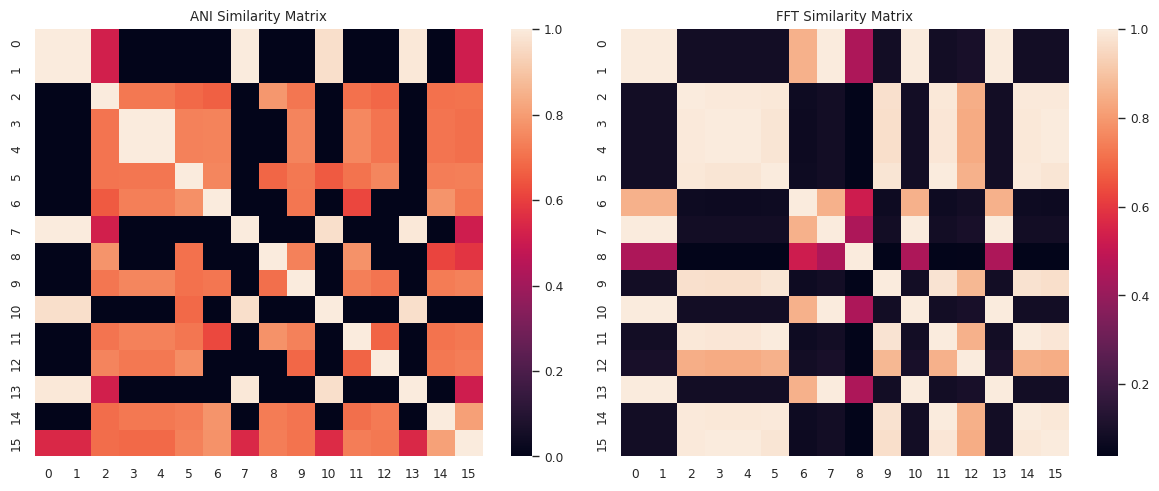

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(sample_batch["ani_mtx"], ax=axes[0], cbar=True)
sns.heatmap(sample_batch["wgt_mtx"], ax=axes[1], cbar=True)
axes[0].set_title("ANI Similarity Matrix")
axes[1].set_title("FFT Similarity Matrix")
plt.tight_layout()
plt.show()

In [103]:
# pyro.render_model(vae.model,model_args=(sample_batch,))

In [104]:
# pyro.render_model(vae.guide,model_args=(sample_batch,))

In [ ]:
def get_learned_params(vae, batch):
    """
    Function to retrive the learned parameters for one pass
    """
    vae.encoder.eval()
    vae.decoder.eval()
    guide_trace = pyro.poutine.trace(vae.guide).get_trace(batch)
    trained_model = pyro.poutine.replay(vae.model, trace=guide_trace)
    trained_trace = pyro.poutine.trace(trained_model).get_trace(batch)
    params = trained_trace.nodes
    return params

In [10]:
for batch in dataloader:
    fft_batch = batch['fft']
    graphs = batch['graphs']
    headers = batch["header"][0]
    headers = [tuple(s.split()[:2]) for s in headers]
    sim_mtx = mg.tl.compute_similarity(fft_batch)
    sim_df = pd.DataFrame(sim_mtx, columns=headers, index=headers)
    sns.clustermap(sim_df, annot=True, fmt=".2f",)
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [61]:
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
# vae.encoder.eval()
z_mu, headers = [], []
for batch in dataloader:
    batch_graphs = batch["graphs"]
    mu, _ = vae.encoder(
        batch_graphs.x,
        batch_graphs.edge_index,
        batch_graphs.edge_weight,
        batch_graphs.batch,
    )
    z_mu.extend(mu.detach().cpu().numpy())
    headers.extend(batch["headers"])

# Flatten the list of headers
headers = [item for sublist in headers for item in sublist]
headers = ["-".join(h.split()[:2]) for h in headers]

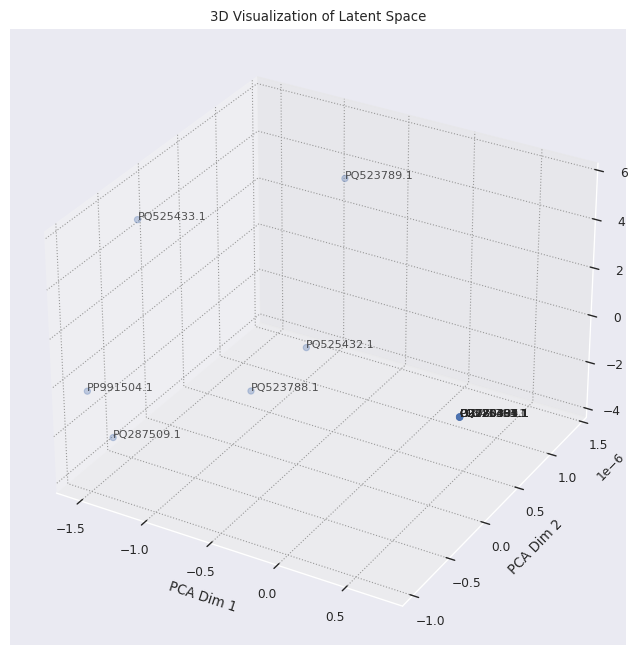

In [82]:
# Convert the list of latent means to a DataFrame
z_df = pd.DataFrame(z_mu, columns=[f"Dim{i}" for i in range(len(z_mu[0]))])

# Apply PCA to reduce dimensionality from 4D to 3D
pca = PCA(n_components=3)
z_3d = pca.fit_transform(z_df)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c='b', marker='o', alpha=.3)

# Annotate each point with its header
for point, header in zip(z_3d, headers):
    ax.text(point[0], point[1], point[2], header, fontsize=8, alpha=0.8)

# Set labels
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_zlabel('PCA Dim 3')
ax.set_title('3D Visualization of Latent Space')

plt.show()

# cosine_sim_matrix = np.corrcoef(z_df.T)

# Create a heatmap of the cosine similarity matrix
# plt.figure(figsize=(12, 10))
# sns.clustermap(cosine_sim_matrix, annot=False, xticklabels=headers, yticklabels=headers, vmin=0, vmax=1)
# plt.title('Cosine Similarity Heatmap')
# plt.show()

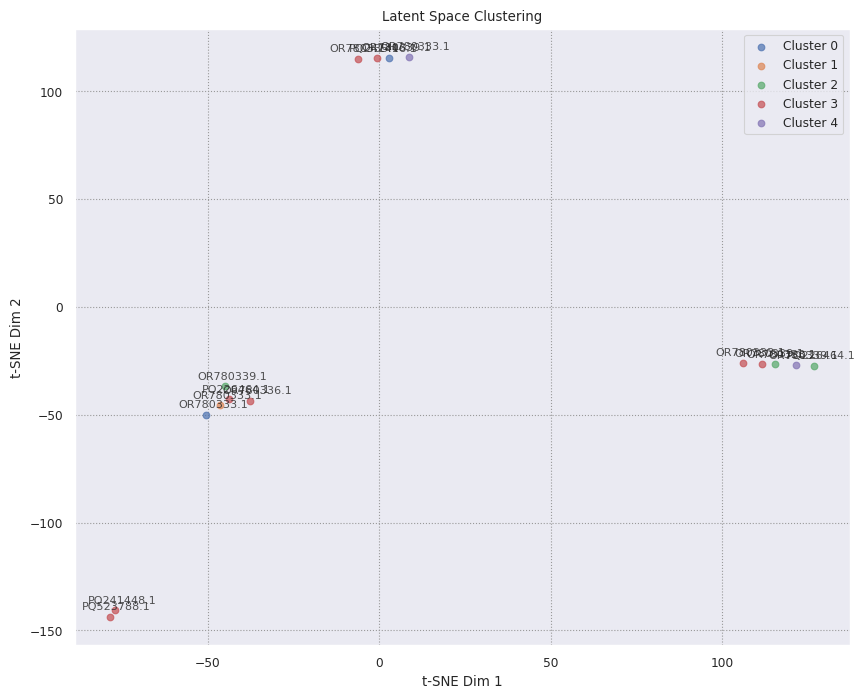

In [85]:
def get_latent_assignments(vae, dataloader):
    vae.encoder.eval()
    vae.decoder.eval()
    num_components = vae.num_components
    latent_embeddings = []
    cluster_assignments = []
    headers = []

    with torch.no_grad():
        for batch in dataloader:
            # Forward pass through the model
            guide_trace = pyro.poutine.trace(vae.guide).get_trace(batch)
            trained_model = pyro.poutine.replay(vae.model, trace=guide_trace)
            trained_trace = pyro.poutine.trace(trained_model).get_trace(batch)

            z_node = trained_trace.nodes["z"]
            z_value = z_node["value"]
            latent_node = trained_trace.nodes["latent"]
            latent_value = latent_node["value"]
            cluster_assignments.append(z_value)
            latent_embeddings.append(latent_value)
            headers.extend(batch["headers"])
            
    latent_embeddings = torch.cat(latent_embeddings, dim=0)
    cluster_assignments = torch.cat(cluster_assignments, dim=0)
    headers = ["-".join(h.split()[:2]) for h in headers[0]]
    
    return latent_embeddings, cluster_assignments, headers

def visualize_clusters(latent_embeddings, cluster_assignments, headers, title="Latent Space Clustering"):
    num_components = vae.config.num_components
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(latent_embeddings), 1))
    latent_2d = tsne.fit_transform(latent_embeddings)

    plt.figure(figsize=(10, 8))
    for cluster in range(num_components):
        cluster_points = latent_2d[cluster_assignments.cpu().numpy() == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)
        for point, header in zip(cluster_points, headers):
            plt.annotate(
                header,
                (point[0], point[1]),
                textcoords="offset points",
                xytext=(5, 5),  # Offset the text to avoid overlap with the point
                ha="center",
                fontsize=8,
                alpha=0.8
            )
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend()
    plt.show()

latent_embeddings, cluster_assignments, _ = get_latent_assignments(vae, dataloader)
visualize_clusters(*get_latent_assignments(vae, dataloader))

In [24]:


sns.clustermap(spearman_sim_matrix, annot=False, xticklabels=headers, yticklabels=headers, vmin=0, vmax=1)
axes[1, 1].set_title('Spearman Rank Correlation')


NameError: name 'spearman_sim_matrix' is not defined